# [EX16] SRGAN 활용하기

#### * 목차
1. 직접 고른 이미지로 SRGAN 실험하기(1)
2. 직접 고른 이미지로 SRGAN 실험하기(2)
3. SRGAN을 이용해 고해상도 gif 생성하기
4. 결과

## 1. 직접 고른 이미지로 SRGAN 실험하기(1)

### 1) 이미지 준비

In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
import os

model_file = os.getenv('HOME')+'/aiffel/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

(361, 377, 3)


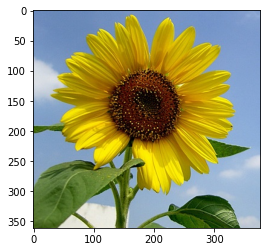

In [8]:
# 높은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러오기
img_path = os.getenv('HOME')+ '/aiffel/super_resolution/image.jpg'

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
print(img.shape)

### 2) 저해상도 이미지만들기

(90, 94, 3)


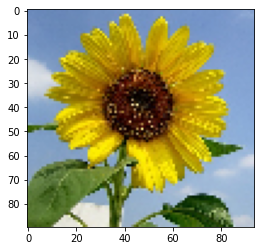

In [9]:
# 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 1/4로 줄이기
img_lr = cv2.resize(img, (img.shape[1]//4, img.shape[0]//4), interpolation=cv2.INTER_CUBIC)

plt.imshow(img_lr)
print(img_lr.shape)

### 3) 저해상도 이미지를 SRGAN을 이용해 고해상도 이미지 생성하기

In [30]:
# 줄인 저해상도 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성하기
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

(360, 376, 3)


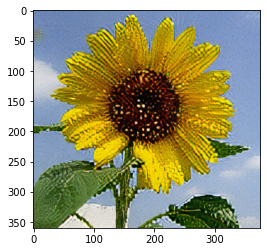

In [6]:
srgan_hr = apply_srgan(img_lr)

plt.imshow(srgan_hr)
print(srgan_hr.shape)

### 4. 저해상도 이미지를 고해상도 이미지로 bicubic interpolation

(1444, 1508, 3)


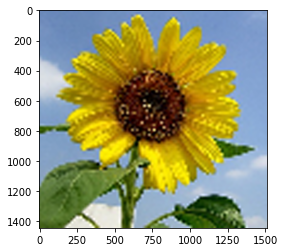

In [110]:
# 2.의 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘리기
hr, lr = np.array(img), np.array(img_lr)

bicubic_hr = cv2.resize(lr , (hr.shape[1]*4, hr.shape[0]*4), interpolation=cv2.INTER_CUBIC)

plt.imshow(bicubic_hr)
print(bicubic_hr.shape)

### 5) Bicubic & SRGAN의 결과, 기존 이미지 시각화

In [11]:
# 특정 영역을 잘라낼 함수를 정의합니다.
def crop(image, left_top, x=50, y=100):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

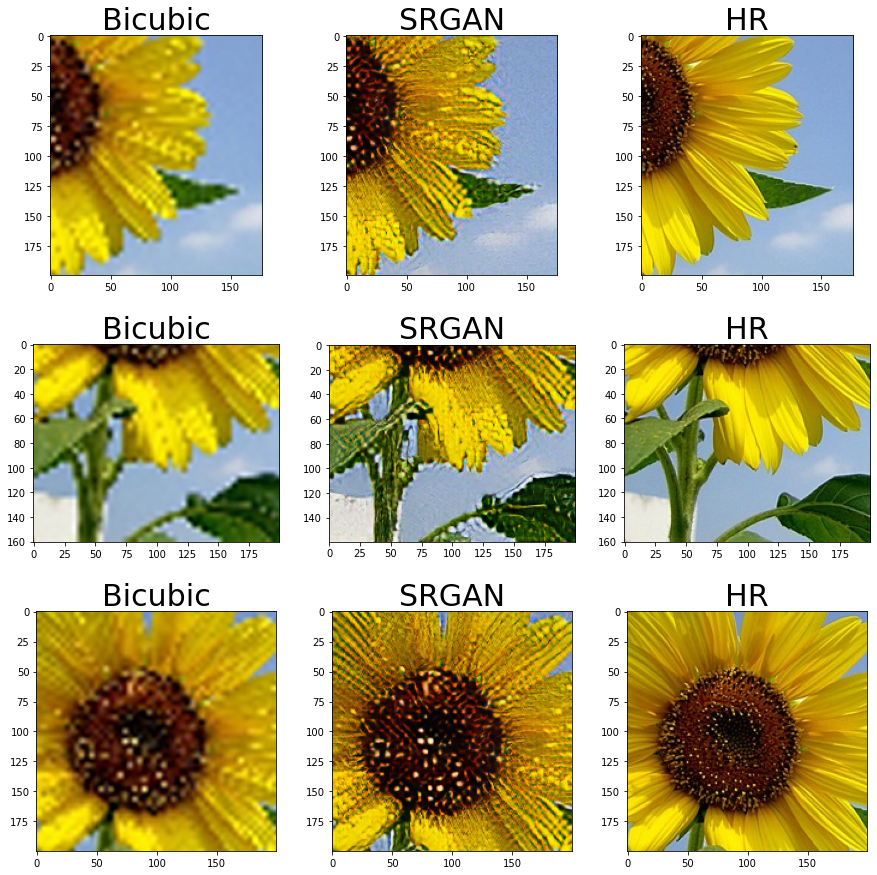

In [20]:
# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 3개 입니다.
left_tops = [(100,200), (200,100), (50,100)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_hr, left_top, 200, 200)
    img2 = crop(srgan_hr , left_top, 200, 200)
    img3 = crop(hr, left_top, 200, 200)
    images.extend([img1, img2, img3])

labels = ["Bicubic", "SRGAN", "HR"] * 3

plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

### # DIV2K 데이터셋을 이용한 SRGAN 모델

#### 데이터 준비하기 

In [21]:
train, valid = tfds.load(
    "div2k/bicubic_x4", 
    split=["train","validation"],
    as_supervised=True
)
def preprocessing(lr, hr):
    hr = tf.cast(hr, tf.float32) /255.
        
    # 이미지의 크기가 크므로 (96,96,3) 크기로 임의 영역을 잘라내어 사용합니다.
    hr_patch = tf.image.random_crop(hr, size=[96,96,3])
        
    # 잘라낸 고해상도 이미지의 가로, 세로 픽셀 수를 1/4배로 줄입니다
    # 이렇게 만든 저해상도 이미지를 SRGAN의 입력으로 사용합니다.
    lr_patch = tf.image.resize(hr_patch, [96//4, 96//4], "bicubic")
    return lr_patch, hr_patch

train = train.map(preprocessing).shuffle(buffer_size=10).repeat().batch(8)
valid = valid.map(preprocessing).repeat().batch(8)

EXTRACTING {'train_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip', 'valid_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip', 'train_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip', 'valid_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip'}


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/800 [00:00<?, ? examples/s]

Shuffling div2k-train.tfrecord...:   0%|          | 0/800 [00:00<?, ? examples/s]

Generating validation examples...:   0%|          | 0/100 [00:00<?, ? examples/s]

Shuffling div2k-validation.tfrecord...:   0%|          | 0/100 [00:00<?, ? examples/s]

Dataset div2k downloaded and prepared to /aiffel/tensorflow_datasets/div2k/bicubic_x4/2.0.0. Subsequent calls will reuse this data.


#### SRGAN 구현하기

In [22]:
from tensorflow.keras import Input, Model, layers

# 그림의 파란색 블록을 정의합니다.
def gene_base_block(x):
    out = layers.Conv2D(64, 3, 1, "same")(x)
    out = layers.BatchNormalization()(out)
    out = layers.PReLU(shared_axes=[1,2])(out)
    out = layers.Conv2D(64, 3, 1, "same")(out)
    out = layers.BatchNormalization()(out)
    return layers.Add()([x, out])

# 그림의 뒤쪽 연두색 블록을 정의합니다.
def upsample_block(x):
    out = layers.Conv2D(256, 3, 1, "same")(x)
    # 그림의 PixelShuffler 라고 쓰여진 부분을 아래와 같이 구현합니다.
    out = layers.Lambda(lambda x: tf.nn.depth_to_space(x, 2))(out)
    return layers.PReLU(shared_axes=[1,2])(out)
    
# 전체 Generator를 정의합니다.
def get_generator(input_shape=(None, None, 3)):
    inputs = Input(input_shape)
    
    out = layers.Conv2D(64, 9, 1, "same")(inputs)
    out = residual = layers.PReLU(shared_axes=[1,2])(out)
    
    for _ in range(5):
        out = gene_base_block(out)
    
    out = layers.Conv2D(64, 3, 1, "same")(out)
    out = layers.BatchNormalization()(out)
    out = layers.Add()([residual, out])
    
    for _ in range(2):
        out = upsample_block(out)
        
    out = layers.Conv2D(3, 9, 1, "same", activation="tanh")(out)
    return Model(inputs, out)


#### Discriminator 구현하기

In [23]:
# 그림의 파란색 블록을 정의합니다.
def disc_base_block(x, n_filters=128):
    out = layers.Conv2D(n_filters, 3, 1, "same")(x)
    out = layers.BatchNormalization()(out)
    out = layers.LeakyReLU()(out)
    out = layers.Conv2D(n_filters, 3, 2, "same")(out)
    out = layers.BatchNormalization()(out)
    return layers.LeakyReLU()(out)

# 전체 Discriminator 정의합니다.
def get_discriminator(input_shape=(None, None, 3)):
    inputs = Input(input_shape)
    
    out = layers.Conv2D(64, 3, 1, "same")(inputs)
    out = layers.LeakyReLU()(out)
    out = layers.Conv2D(64, 3, 2, "same")(out)
    out = layers.BatchNormalization()(out)
    out = layers.LeakyReLU()(out)
    
    for n_filters in [128, 256, 512]:
        out = disc_base_block(out, n_filters)
    
    out = layers.Dense(1024)(out)
    out = layers.LeakyReLU()(out)
    out = layers.Dense(1, activation="sigmoid")(out)
    return Model(inputs, out)

In [24]:
from tensorflow.python.keras import applications
def get_feature_extractor(input_shape=(None, None, 3)):
    vgg = applications.vgg19.VGG19(
        include_top=False, 
        weights="imagenet", 
        input_shape=input_shape
    )
    # 아래 vgg.layers[20]은 vgg 내의 마지막 convolutional layer 입니다.
    return Model(vgg.input, vgg.layers[20].output)

#### SRGAN 학습하기

In [25]:
from tensorflow.keras import losses, metrics, optimizers

generator = get_generator()
discriminator = get_discriminator()
vgg = get_feature_extractor()

# 사용할 loss function 및 optimizer 를 정의합니다.
bce = losses.BinaryCrossentropy(from_logits=False)
mse = losses.MeanSquaredError()
gene_opt = optimizers.Adam()
disc_opt = optimizers.Adam()

def get_gene_loss(fake_out):
    return bce(tf.ones_like(fake_out), fake_out)

def get_disc_loss(real_out, fake_out):
    return bce(tf.ones_like(real_out), real_out) + bce(tf.zeros_like(fake_out), fake_out)


@tf.function
def get_content_loss(hr_real, hr_fake):
    hr_real = applications.vgg19.preprocess_input(hr_real)
    hr_fake = applications.vgg19.preprocess_input(hr_fake)
    
    hr_real_feature = vgg(hr_real) / 12.75
    hr_fake_feature = vgg(hr_fake) / 12.75
    return mse(hr_real_feature, hr_fake_feature)


@tf.function
def step(lr, hr_real):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        hr_fake = generator(lr, training=True)
        
        real_out = discriminator(hr_real, training=True)
        fake_out = discriminator(hr_fake, training=True)
        
        perceptual_loss = get_content_loss(hr_real, hr_fake) + 1e-3 * get_gene_loss(fake_out)
        discriminator_loss = get_disc_loss(real_out, fake_out)
        
    gene_gradient = gene_tape.gradient(perceptual_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(discriminator_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return perceptual_loss, discriminator_loss


gene_losses = metrics.Mean()
disc_losses = metrics.Mean()

for epoch in range(1, 2):
    for i, (lr, hr) in enumerate(train):
        g_loss, d_loss = step(lr, hr)
        
        gene_losses.update_state(g_loss)
        disc_losses.update_state(d_loss)
        
        # 10회 반복마다 loss를 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \nGenerator_loss:{gene_losses.result():.4f} \nDiscriminator_loss:{disc_losses.result():.4f}", end="\n\n")
        
        if (i+1) == 200:
            break
            
    gene_losses.reset_states()
    disc_losses.reset_states()

80142336/80134624 [==============================] - 1s 0us/step
EPOCH[1] - STEP[10] 
Generator_loss:0.0011 
Discriminator_loss:1.5646

EPOCH[1] - STEP[20] 
Generator_loss:0.0013 
Discriminator_loss:1.1604

EPOCH[1] - STEP[30] 
Generator_loss:0.0015 
Discriminator_loss:0.9883

EPOCH[1] - STEP[40] 
Generator_loss:0.0019 
Discriminator_loss:0.7883

EPOCH[1] - STEP[50] 
Generator_loss:0.0025 
Discriminator_loss:0.6380

EPOCH[1] - STEP[60] 
Generator_loss:0.0029 
Discriminator_loss:0.5353

EPOCH[1] - STEP[70] 
Generator_loss:0.0033 
Discriminator_loss:0.4636

EPOCH[1] - STEP[80] 
Generator_loss:0.0036 
Discriminator_loss:0.4092

EPOCH[1] - STEP[90] 
Generator_loss:0.0039 
Discriminator_loss:0.3686

EPOCH[1] - STEP[100] 
Generator_loss:0.0042 
Discriminator_loss:0.3341

EPOCH[1] - STEP[110] 
Generator_loss:0.0045 
Discriminator_loss:0.3047

EPOCH[1] - STEP[120] 
Generator_loss:0.0047 
Discriminator_loss:0.2819

EPOCH[1] - STEP[130] 
Generator_loss:0.0048 
Discriminator_loss:0.2610

EPOCH[1]

## 2. 직접 고른 이미지로 SRGAN 실험하기(2)

### 1) 이미지 준비
낮은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러옵니다.

(500, 398, 3)


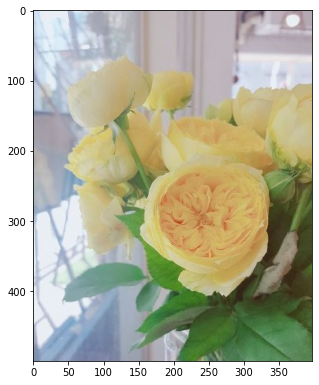

In [53]:
img_path = os.getenv('HOME')+ '/aiffel/super_resolution/image2.jpg'

img_lr2 = cv2.imread(img_path)
img_lr2 = cv2.cvtColor(img_lr2, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(5,10))
plt.imshow(img_lr2)
print(img_lr2.shape)

### 2) SRGAN 이미지 생성
불러온 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성

(2000, 1592, 3)


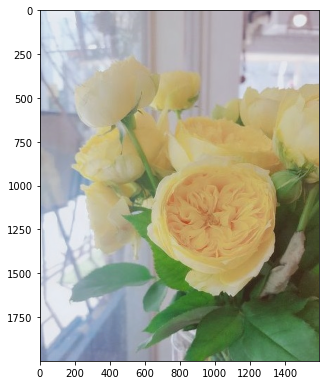

In [54]:
srgan_hr2 = apply_srgan(img_lr2)

plt.figure(figsize=(5,10))
plt.imshow(srgan_hr2)
print(srgan_hr2.shape)

### 3) 1.에서 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘리기

(2000, 1592, 3)


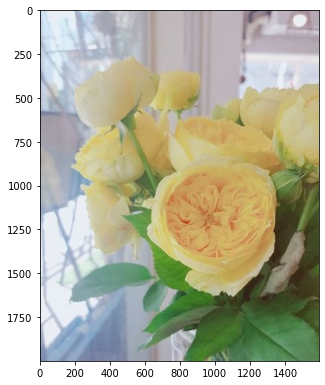

In [57]:
bicubic_hr2 = cv2.resize(img_lr2, dsize=(img_lr2.shape[1]*4, img_lr2.shape[0]*4), interpolation=cv2.INTER_CUBIC)

plt.figure(figsize=(5,10))
plt.imshow(bicubic_hr2)
print(bicubic_hr2.shape)

### 4) Bicubic & SRGAN의 결과 이미지 시각화

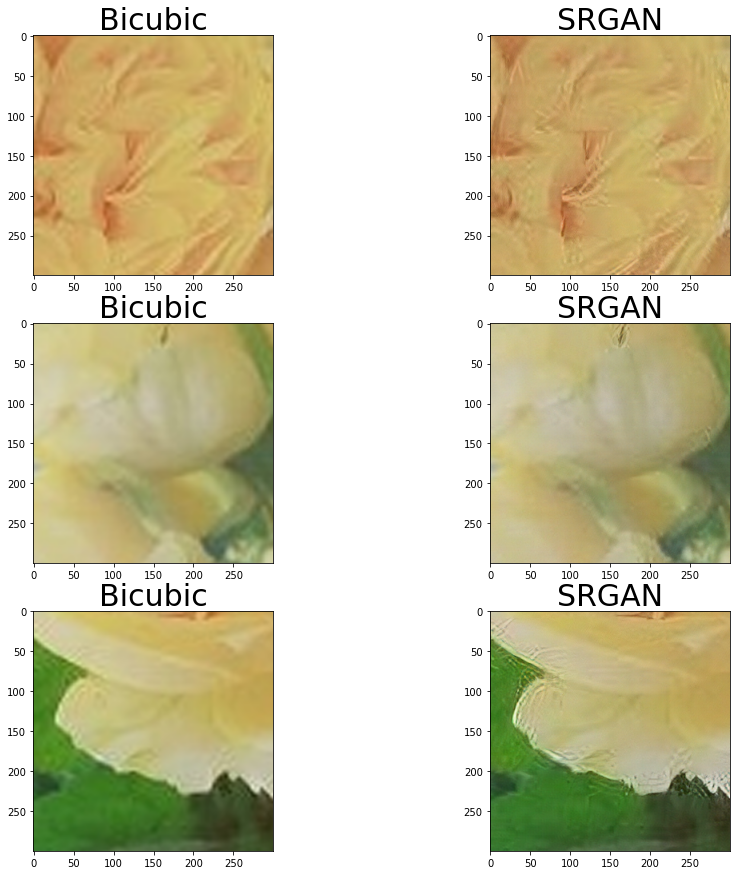

In [84]:
# 자세히 시각화 하기 위해 2개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 2개 입니다.
left_tops = [(1000,1000), (800,300), (1400,800)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_hr2, left_top, 300, 300)
    img2 = crop(srgan_hr2, left_top, 300, 300)
    images.extend([img1, img2])

labels = ["Bicubic", "SRGAN"] * 3

plt.figure(figsize=(15,15))
for i in range(6):
    plt.subplot(3,2,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

## 3. SRGAN을 이용해 고해상도 gif 생성하기

### 1. gif 파일 불러오기

frame 수 : 14
frame 크기 : (282, 300, 3)


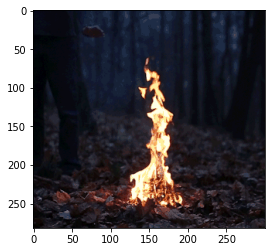

In [88]:
import cv2

# 다운받은 파일의 경로를 설정해 주세요.
gif_path = os.getenv('HOME')+ '/aiffel/super_resolution/fire_lr.gif'
gif = cv2.VideoCapture(gif_path)

isTrue = True
frames = []
while isTrue:
    isTrue, frame = gif.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

print("frame 수 :", len(frames))
print("frame 크기 :", (frames[0].shape))

plt.imshow(frames[0])

### 2. 프레임별 Super Resolution 진행하기

#### Bicubic interpolation과 SRGAN을 이용해 각각의 가로, 세로 픽셀 수를 4배로 늘려봅시다.

In [97]:
# Bicubic interpolation
frames_bicubic = []

for i in range(len(frames)):
    gif_hr = cv2.resize(frames[i], (frames[i].shape[1]*4, frames[i].shape[0]*4), interpolation=cv2.INTER_CUBIC)
    frames_bicubic.append(gif_hr)

In [98]:
# SRGAN
frames_srgan = []

for i in range(len(frames)):
    gif_hr = apply_srgan(frames[i])
    frames_srgan.append(gif_hr)

### 3. 프레임을 합쳐 gif 만들기

import imageio

imageio.mimsave("fire_bicubic.gif", frames_bicubic)
imageio.mimsave("fire_srgan.gif", frames_srgan)

### 4. Jupyter notebook에 gif 표시하기

In [1]:
from IPython.display import Image as show_gif
show_gif("fire_lr.gif", width=200)

<img src="https://github.com/olivela777/AIFFEL/blob/main/16_EXPLORATION/fire_lr.gif?raw=true" width="300">

In [2]:
show_gif("fire_bicubic.gif", width=200)

<img src="https://github.com/olivela777/AIFFEL/blob/main/16_EXPLORATION/fire_bicubic.gif?raw=true" width="300">

In [3]:
show_gif("fire_srgan.gif", width=200)

<img src="https://github.com/olivela777/AIFFEL/blob/main/16_EXPLORATION/fire_srgan.gif?raw=true" width="300">

## 4. 결과

#### 결과
* 해바라기, 노랑 꽃 이미지      
    - Bicubic 이미지 : 경계선이 뭉개져보임            
    - SRGAN 이미지 : 전체적으로는 선명하게 보이지만, 이 떄문에 픽셀이 도드라져 부자연스러움     
        --> SRGAN 이미지가 원본 이미지에 가장 가깝다.   
 

* 모닥불 gif 이미지       
    - Bicubic 이미지 : 장작이 살짝 뭉개져보인다.   
    - SRGAN 이미지 : Bicubic 이미지보다 상대적으로 장작이 선명하게 보임      

#### SRGAN
* SRGAN(super-resolution generative adversarial network)   
저해상도(LR)에서 고해상도(HR)이미지를 추정하는 매우 어려운 작업을 SR(Super-resolution)이라고 한다.  
SR 모델 중 하나인 SRGAN은  VGG network의 high-level feature map을 이용하여 perceptual loss을 구하고,    
이를 기반으로 4배 upscale 이미지를 출력 해준다고 한다.  


* SRGAN 관련 논문 : Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network(, 2017)        
위 논문에 의하면, PSNR이 높을수록 원본 이미지와 차이가 적다는 것을 의미하는데    
PSNR이 가장 낮은 SRGAN이 육안으로 봤을 때 가장 원본 이미지와 유사함을 느낄 수 있다고 한다.    
하지만 PSNR과 MSE가 디테일에 관련된 부분을 생각하면 절대적인 측정 방법이 아니라는 것도 언급하고 있다.    